# GOLD PRICE PREDICTION ML (Random Forest and Linear Regression) 

# Importing modules and library

In [1]:
import pandas_datareader as pdr 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

### Import Gold price from Yahoo API 

In [20]:
# Reading Gold price from yahoo finance server    
data = pdr.DataReader('GC=F', 'yahoo', start='2019-01-29') 

# Look at the data read
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,1765.699951,1750.000000,1754.000000,1762.900024,3485.0,1762.900024
2022-08-01,1772.500000,1756.099976,1763.900024,1769.000000,705.0,1769.000000
2022-08-02,1786.599976,1759.400024,1772.099976,1771.099976,1078.0,1771.099976
2022-08-03,1770.500000,1753.000000,1756.699951,1758.000000,399.0,1758.000000
2022-08-05,1811.599976,1801.800049,1807.699951,1802.199951,34515.0,1802.199951


### Basic information about dataset 

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 888 entries, 2019-01-29 to 2022-08-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       888 non-null    float64
 1   Low        888 non-null    float64
 2   Open       888 non-null    float64
 3   Close      888 non-null    float64
 4   Volume     888 non-null    float64
 5   Adj Close  888 non-null    float64
dtypes: float64(6)
memory usage: 48.6 KB


In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
High,888.0,1703.934685,204.652672,1269.800049,1524.374969,1780.549988,1851.299957,2072.000000
Low,888.0,1686.400901,200.675115,1266.000000,1504.674957,1763.100037,1833.299957,2040.000000
Open,888.0,1695.122749,202.612773,1266.400024,1513.500031,1771.950012,1841.925018,2053.600098
Close,888.0,1695.237273,202.645111,1269.300049,1513.475037,1770.600037,1842.749969,2051.500000
Volume,888.0,5464.595721,29073.636469,0.000000,70.750000,220.500000,670.500000,346362.000000
Adj Close,888.0,1695.237273,202.645111,1269.300049,1513.475037,1770.600037,1842.749969,2051.500000


## Analyze the saisonality and trand of the Gold market over the time

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(data, column_name):
    """
    Function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_add = seasonal_decompose(x=data['Open'], model='additive', extrapolate_trend='freq', period=int(len(data)/2))
    result_mul = seasonal_decompose(x=data['Open'], model='multiplicative', extrapolate_trend='freq', period=int(len(data)/2))


    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_mul, result_add

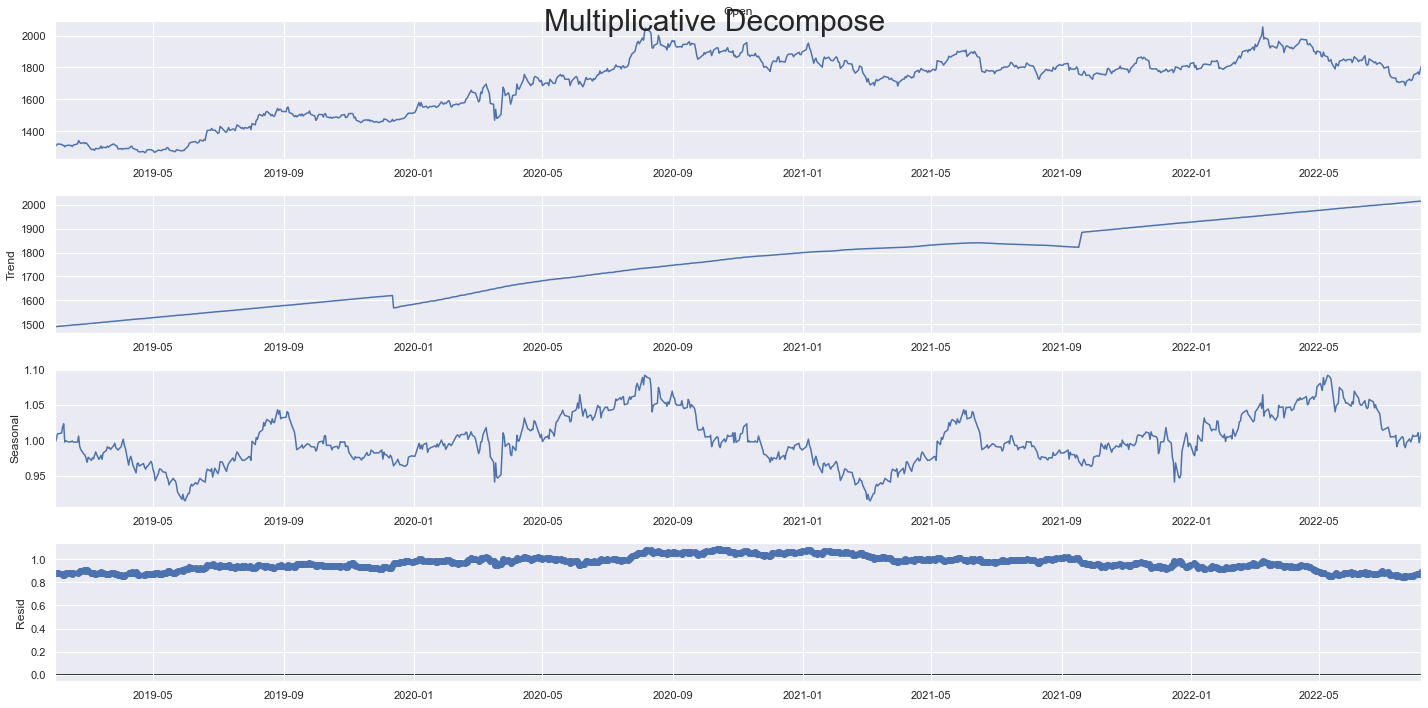

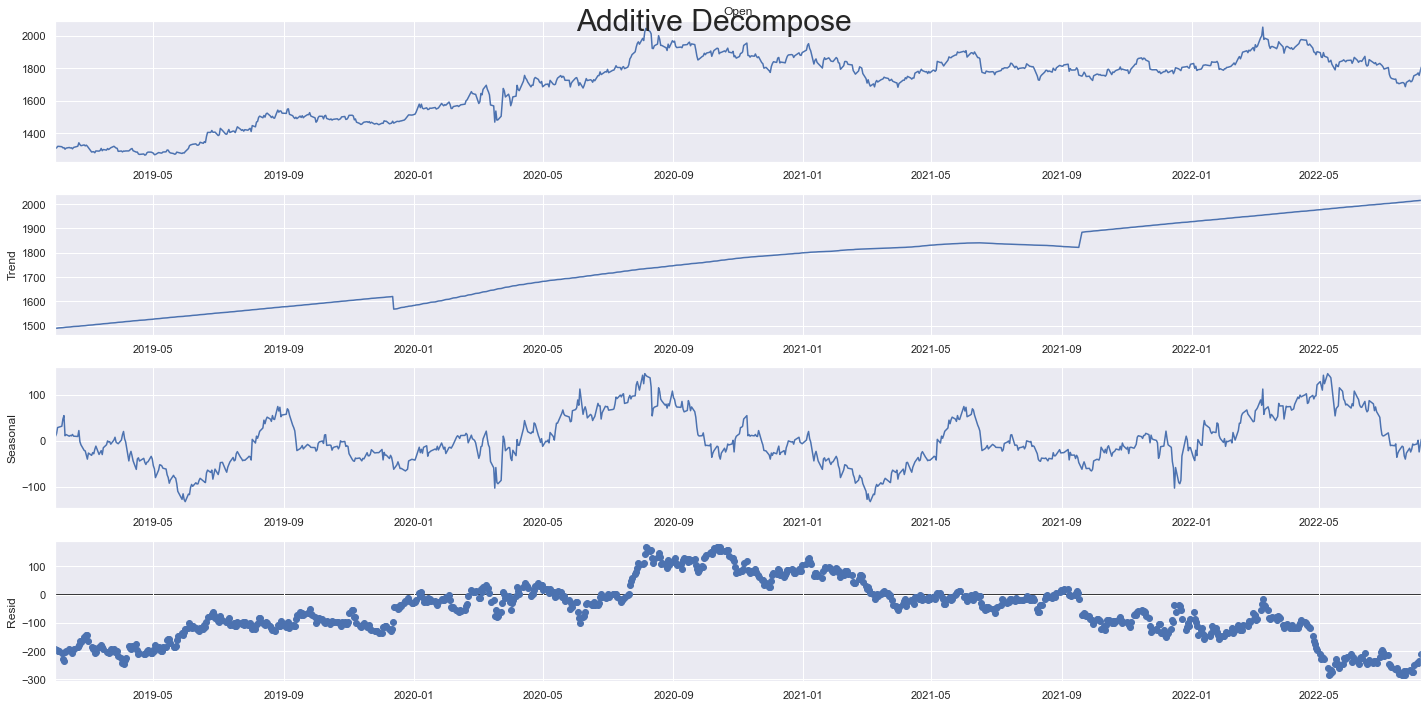

In [24]:
result_mul, result_add = decompose(data, 'Open')

### Basic plots to see relationship with price opening and closing

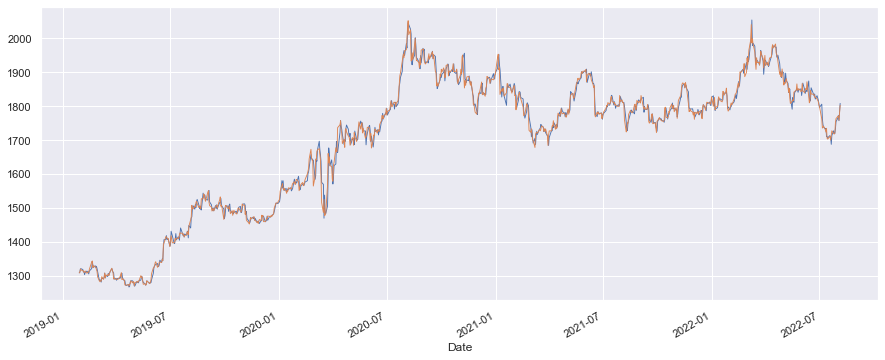

In [25]:
sns.set(rc={'figure.figsize':(15, 6)})
data['Open'].plot(linewidth=0.9);
data['Close'].plot(linewidth=0.9);

### Analyzing features distibution 

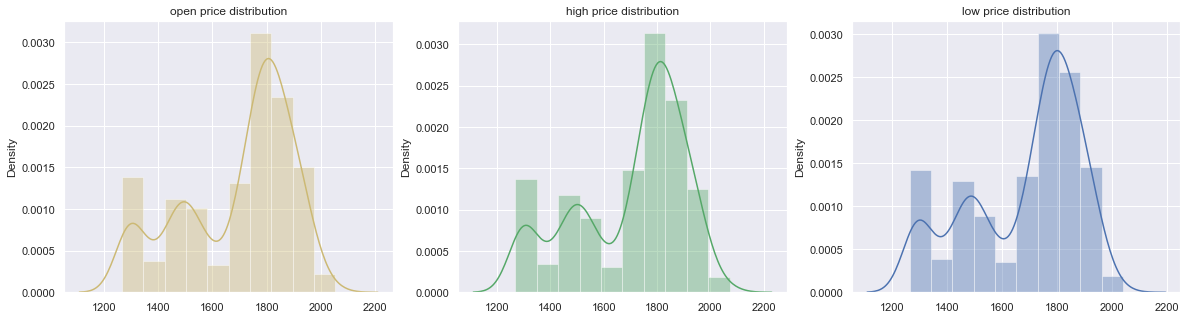

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.distplot(ax = axes[0], x = data["Open"], hist = True, bins = 10, kde = True,
             vertical = False, color = "y").set(title = "open price distribution");

sns.distplot(ax = axes[1], x = data["High"], hist = True, bins = 10, kde = True,
             vertical = False, color = "g").set(title = "high price distribution");

sns.distplot(ax = axes[2], x = data["Low"], hist = True, bins = 10, kde = True,
             vertical = False, color = "b").set(title = "low price distribution");



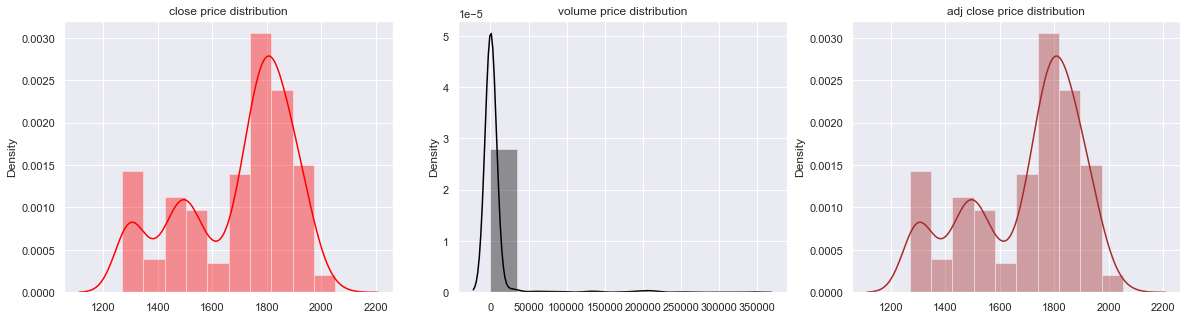

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.distplot(ax = axes[0], x = data["Close"], hist = True, bins = 10, kde = True,
             vertical = False, color = "red").set(title = "close price distribution");

sns.distplot(ax = axes[1], x = data["Volume"], hist = True, bins = 10, kde = True,
             vertical = False, color = "Black").set(title = "volume price distribution");

sns.distplot(ax = axes[2], x = data["Adj Close"], hist = True, bins = 10, kde = True,
             vertical = False, color = "brown").set(title = "adj close price distribution");

### Get a confirmation of the overcorrelation 

<AxesSubplot:>

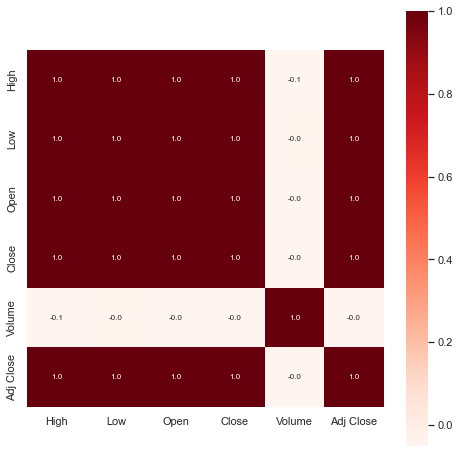

In [28]:
corr = data.corr()
plt.figure(figsize= (8,8))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Reds')

# Deciding to take only Opening price to continue 

In [29]:
data = data[['Open']]


## Plotting ACF 
### Autocorrelation (ACF) is a calculated value used to represent how similar a value within a time series is to a previous value.
#### Anything within this range represents a value that has no significant correlation with the most recent value for the price.

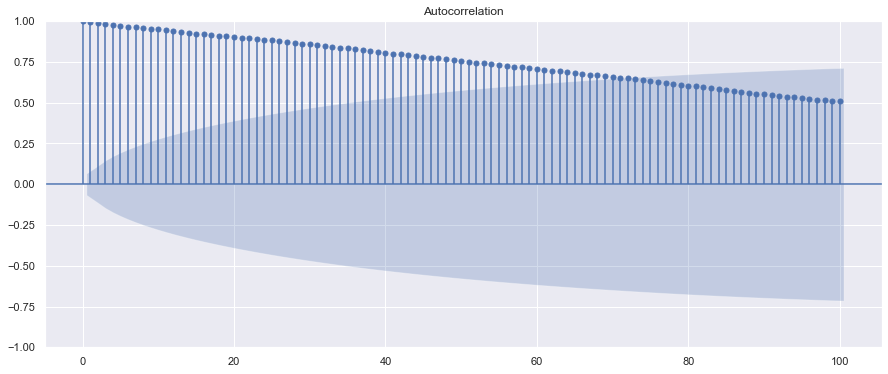

In [30]:
plot_acf(data.Open, lags=100)
# Show the AR as a plot
plt.show()

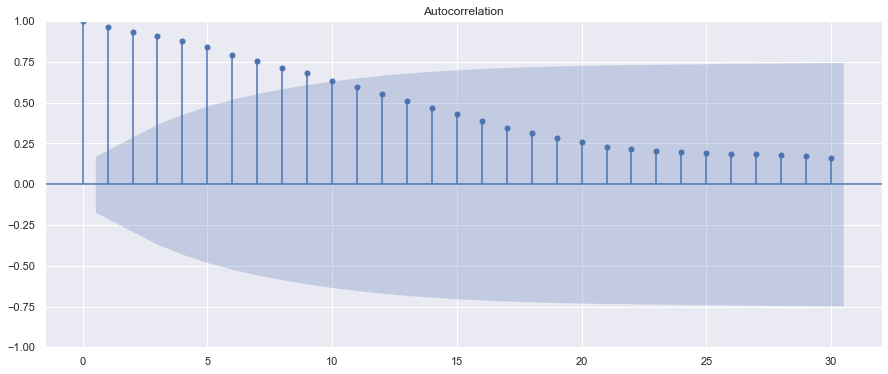

In [31]:
short = pdr.DataReader('GC=F', 'yahoo', start='2022-01-29')
short = short[['Open']]
plot_acf(short.Open, lags=30)
# Show the AR as a plot
plt.show()

# Keeping only 1 month price

In [86]:
data = pdr.DataReader('GC=F', 'yahoo', start='2022-07-26')

In [87]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,1765.699951,1750.000000,1754.000000,1762.900024,3485.0,1762.900024
2022-08-01,1772.500000,1756.099976,1763.900024,1769.000000,705.0,1769.000000
2022-08-02,1786.599976,1759.400024,1772.099976,1771.099976,1078.0,1771.099976
2022-08-03,1770.500000,1753.000000,1756.699951,1758.000000,399.0,1758.000000
2022-08-05,1811.599976,1801.800049,1807.699951,1802.900024,35166.0,1802.900024


## Make a new column of Opening and Closing price mean

In [88]:
data['Mean'] = data.Open 
data = data[['Mean']]

## TA-Lib is a powerful finance library to extract tools like indicators such as Moving Average, MACD, RSI, Stochastic, Bollinger Bands, etc.

In [89]:
data.ta.ema(close='Mean', length=2, append=True)

Date
2022-07-26            NaN
2022-07-27    1718.549988
2022-07-28    1727.716695
2022-07-29    1745.238898
2022-08-01    1757.679649
2022-08-02    1767.293200
2022-08-03    1760.231034
2022-08-05    1791.876979
Name: EMA_2, dtype: float64

### Loc from the not Nan row 

In [90]:
data = data.iloc[1:]
data.head()

,Mean,EMA_2
Date,,
2022-07-27,1719.099976,1718.549988
2022-07-28,1732.300049,1727.716695
2022-07-29,1754.000000,1745.238898
2022-08-01,1763.900024,1757.679649
2022-08-02,1772.099976,1767.293200


<AxesSubplot:xlabel='Date'>

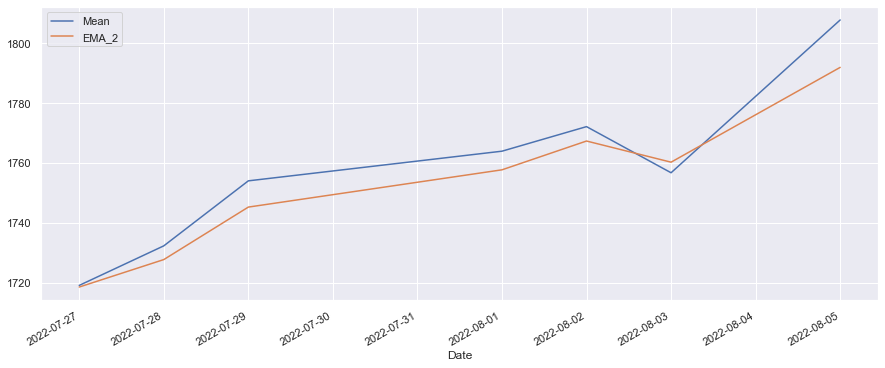

In [91]:
data.plot()

<AxesSubplot:xlabel='EMA_2', ylabel='Density'>

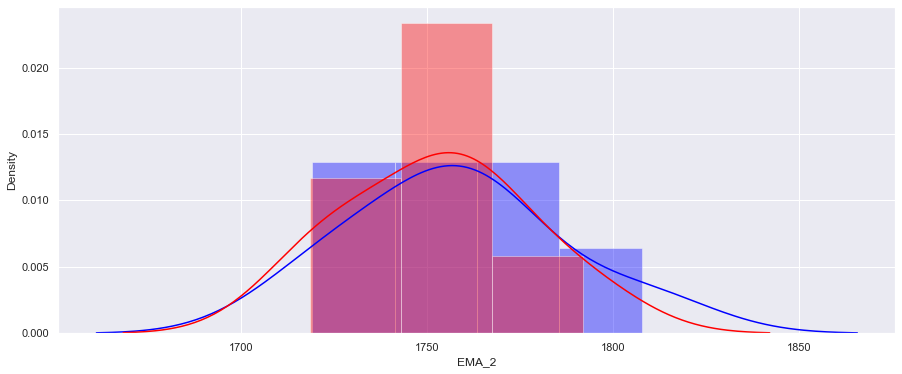

In [92]:
sns.distplot(data['Mean'], color='blue')
sns.distplot(data['EMA_2'], color='red')

### Split data into testing and training sets

In [93]:

X_train, X_test, y_train, y_test = train_test_split(data[['Mean']], data[['EMA_2']], test_size=.2)


In [94]:
X_test.describe()

,Mean
count,2.000000
mean,1764.399963
std,10.889462
min,1756.699951
25%,1760.549957
50%,1764.399963
75%,1768.249969
max,1772.099976


In [95]:
X_train.describe()

,Mean
count,5.000000
mean,1755.400000
std,34.135007
min,1719.099976
25%,1732.300049
50%,1754.000000
75%,1763.900024
max,1807.699951


# Linear Regession

In [96]:
from sklearn.linear_model import LinearRegression
# Create Regression Model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Use model to make predictions
y_pred = model.predict(X_test)

In [97]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Printout relevant metrics

print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Model Coefficients: [[0.84073346]]
Mean Absolute Error: 7.983104913187617
Coefficient of Determination: -4.805705481935671


In [98]:
y_pred = clf.predict(X_train)

In [99]:
X_train['Prediction'] = y_pred.tolist()

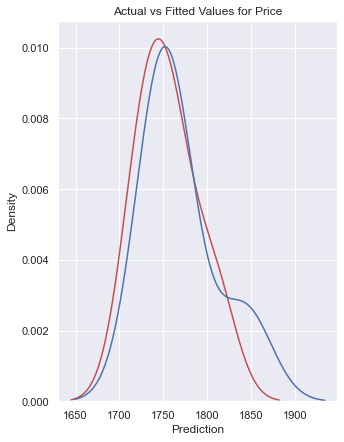

In [100]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(X_train['Mean'], hist=False, color="r", label="Actual Value")
sns.distplot(X_train['Prediction'], hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()

<AxesSubplot:xlabel='Date'>

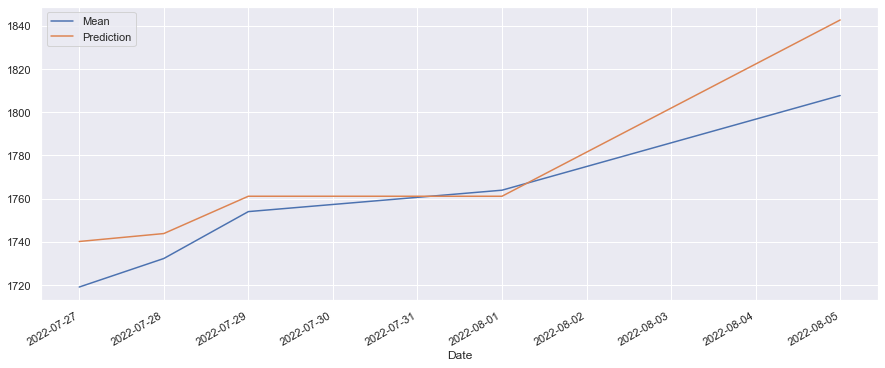

In [101]:
X_train.plot()

# Ramdom Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=5,n_estimators=100)
clf.fit(X_train, y_train)

clf.score(X_test,y_test),clf.score(X_train,y_train)

(0.9380474034915605, 0.9765107053515565)

In [45]:
y_pred = clf.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Mean Absolute Error: 6.867205766091411
Coefficient of Determination: 0.9380474034915605


### Mean Absolute Error 0,17 so Bad!

# Try again with more data ! Lets's try 6 months

In [46]:
data = pdr.DataReader('GC=F', 'yahoo', start='2022-01-29', end='2022-07-29')

In [47]:
data['Mean'] = data.Open
data = data[['Mean']]


In [48]:
data.ta.ema(close='Mean', length=10, append=True)

Date
2022-01-31            NaN
2022-02-01            NaN
2022-02-02            NaN
2022-02-03            NaN
2022-02-04            NaN
                 ...     
2022-07-25    1720.175156
2022-07-26    1719.779673
2022-07-27    1719.656092
2022-07-28    1721.954993
2022-07-29    1727.781358
Name: EMA_10, Length: 125, dtype: float64

In [49]:
data = data.iloc[10:]
data.head()

,Mean,EMA_10
Date,,
2022-02-14,1861.800049,1819.999108
2022-02-15,1872.599976,1829.562902
2022-02-16,1858.699951,1834.860547
2022-02-17,1876.300049,1842.395002
2022-02-18,1899.400024,1852.759552


# Linear Regession

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data[['Mean']], data[['EMA_10']], test_size=.2)

In [51]:
from sklearn.linear_model import LinearRegression
# Create Regression Model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
# Use model to make predictions
y_pred = model.predict(X_test)

In [52]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Printout relevant metrics

print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Model Coefficients: [[0.83154999]]
Mean Absolute Error: 17.566430790350463
Coefficient of Determination: 0.895189444231352


# Ramdom Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=2,n_estimators=90)
clf.fit(X_train, y_train)

clf.score(X_test,y_test),clf.score(X_train,y_train)

(0.9306924072783621, 0.911356371588208)

In [54]:
y_pred = clf.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Mean Absolute Error: 12.91865647019114
Coefficient of Determination: 0.9306924072783621


# MEA of 85 is not bad :) 

In [55]:
y_pred = clf.predict(X_train)

In [56]:
X_train['Prediction'] = y_pred.tolist()

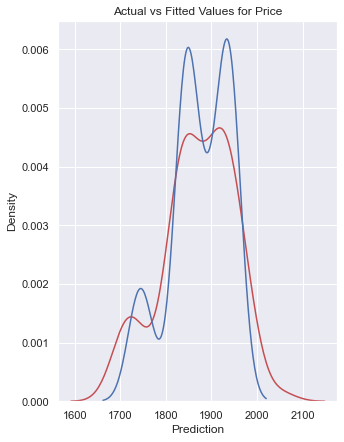

In [57]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(X_train['Mean'], hist=False, color="r", label="Actual Value")
sns.distplot(X_train['Prediction'], hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()

<AxesSubplot:xlabel='Date'>

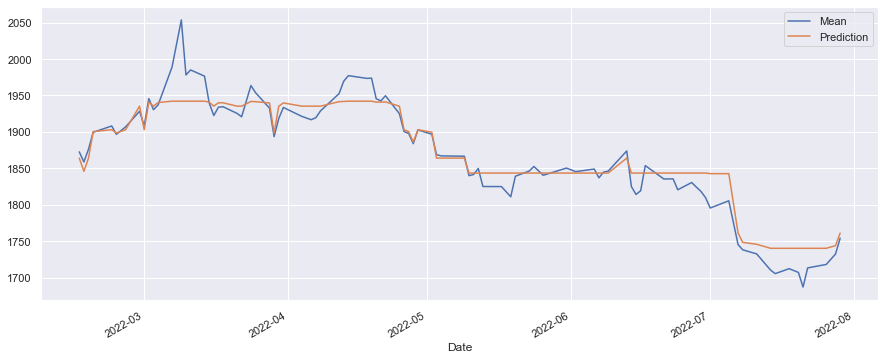

In [58]:
X_train.plot()